Importo las librerías necesarias

In [2]:
import pandas as pd
import numpy as np
import fastparquet
import pyarrow
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from collections import Counter
from sklearn.metrics import silhouette_samples, silhouette_score
import random
from sklearn.preprocessing import StandardScaler

Traigo el dataset que voy a usar.

In [3]:
df_test = pd.read_parquet('test.parquet')

Primera mirada a los datos

In [4]:
df_test.head()

,id,url,region,region_url,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7037609789,https://annarbor.craigslist.org/apa/d/wixom-ho...,ann arbor,https://annarbor.craigslist.org,manufactured,1344,3,2.0,0,0,...,0,0,0,w/d in unit,off-street parking,https://images.craigslist.org/00M0M_iNczP1nzIL...,"OPEN HOUSE TODAY! APPLY THIS WEEK, PUT A HOLDI...",42.5333,-83.5763,mi
1,7032406876,https://vermont.craigslist.org/apa/d/randolph-...,vermont,https://vermont.craigslist.org,apartment,1050,2,1.0,0,0,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00L0L_ecirmYBIzL...,"Think of it, you'll be first to get your mail....",43.9393,-72.5538,vt
2,7037022682,https://annarbor.craigslist.org/apa/d/ann-arbo...,ann arbor,https://annarbor.craigslist.org,apartment,1150,2,2.0,1,1,...,1,0,0,w/d in unit,carport,https://images.craigslist.org/00e0e_dPln2xjo9g...,One of Ann Arbor's most luxurious apartment co...,42.2492,-83.7712,mi
3,7048681802,https://fortcollins.craigslist.org/apa/d/fort-...,fort collins / north CO,https://fortcollins.craigslist.org,apartment,1280,2,2.5,1,1,...,0,0,0,w/d in unit,attached garage,https://images.craigslist.org/00L0L_jlektT5cSd...,"Specials! Move in before January 16th, 2020 an...",40.5501,-105.0350,co
4,7043597870,https://charlottesville.craigslist.org/apa/d/c...,charlottesville,https://charlottesville.craigslist.org,apartment,783,2,1.0,1,1,...,0,0,0,laundry on site,None,https://images.craigslist.org/00D0D_cXa4KbZ6ox...,Barracks West Apartments & Townhomes in Charlo...,38.0936,-78.5611,va


Veo la información mas detallada del Dataset.

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38498 entries, 0 to 38497
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       38498 non-null  int64  
 1   url                      38498 non-null  object 
 2   region                   38498 non-null  object 
 3   region_url               38498 non-null  object 
 4   type                     38498 non-null  object 
 5   sqfeet                   38498 non-null  int64  
 6   beds                     38498 non-null  int64  
 7   baths                    38498 non-null  float64
 8   cats_allowed             38498 non-null  int64  
 9   dogs_allowed             38498 non-null  int64  
 10  smoking_allowed          38498 non-null  int64  
 11  wheelchair_access        38498 non-null  int64  
 12  electric_vehicle_charge  38498 non-null  int64  
 13  comes_furnished          38498 non-null  int64  
 14  laundry_options       

In [6]:
df_test.isnull().sum()

id                             0
url                            0
region                         0
region_url                     0
type                           0
sqfeet                         0
beds                           0
baths                          0
cats_allowed                   0
dogs_allowed                   0
smoking_allowed                0
wheelchair_access              0
electric_vehicle_charge        0
comes_furnished                0
laundry_options             7855
parking_options            14005
image_url                      0
description                    0
lat                          196
long                         196
state                          0
dtype: int64

Saco las columnas que no voy a usar

In [7]:
df_test.drop(['laundry_options', 'parking_options', 'url', 'region_url', 'region', 'image_url', 'id', 'cats_allowed', 'dogs_allowed', 'wheelchair_access', 'lat', 'long', 'smoking_allowed', 'state', 'description','state', 'type'], axis=1, inplace=True)

In [8]:
df_test.columns

Index(['sqfeet', 'beds', 'baths', 'electric_vehicle_charge',
       'comes_furnished'],
      dtype='object')

Escalo la data y veo el resultado

In [9]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_test)

pd.DataFrame(data_scaled).describe()

,0,1,2,3,4
count,3.849800e+04,3.849800e+04,3.849800e+04,3.849800e+04,3.849800e+04
mean,7.198080e-17,3.691323e-19,5.536984e-17,-1.845661e-17,3.691323e-19
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-1.458767e+00,-3.397390e-01,-2.119523e+00,-1.173551e-01,-2.245505e-01
25%,-3.669441e-01,-1.632282e-01,-6.913970e-01,-1.173551e-01,-2.245505e-01
50%,-8.015867e-02,1.328255e-02,-6.913970e-01,-1.173551e-01,-2.245505e-01
75%,2.153614e-01,1.328255e-02,7.367285e-01,-1.173551e-01,-2.245505e-01
max,1.371911e+02,1.938221e+02,1.049899e+02,8.521147e+00,4.453342e+00


Defino la función kmeans y entreno el modelo

In [10]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=3, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

/home/monica/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

Calculo la inercia, que mide cuán bien el dataset se ajusta a los clusters

In [11]:
# inertia on the fitted data
kmeans.inertia_

105166.56900387483

Calculo la inercia en distinto número de clusters para poder visualizarla.

In [12]:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

/home/monica/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/monica/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/monica/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/monica/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/monica/.local/lib/python3.

Grafico

Text(0, 0.5, 'Inertia')

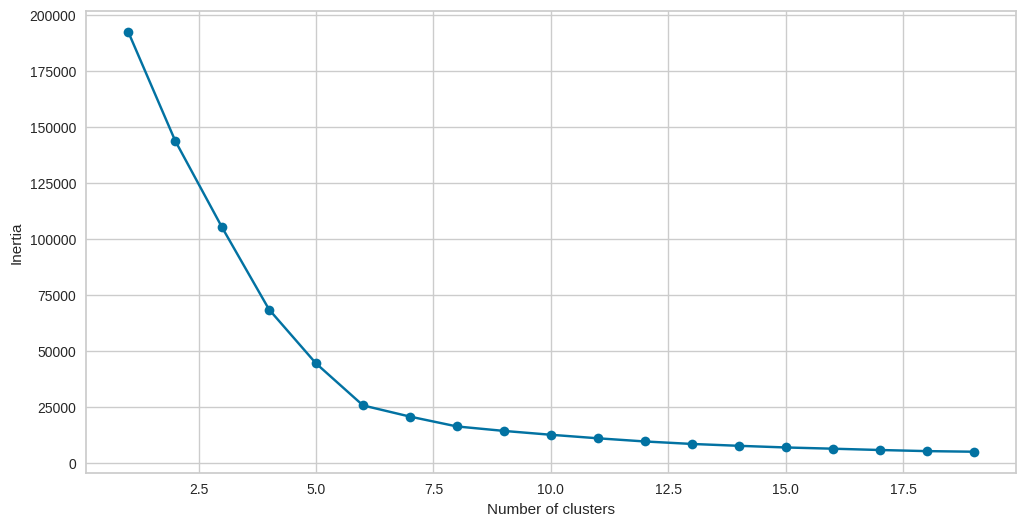

In [13]:
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Hago la predicción con 3 clusters

In [14]:
kmeans = KMeans(n_clusters = 3, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

/home/monica/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
len(pred)

38498

In [16]:
monicaV84 = pd.DataFrame(data=pred, columns=['pred']).set_index('pred')
monicaV84

""
pred
1
1
1
1
1
...
1
1
1


In [17]:
monicaV84.to_csv('monicaV84.csv')